# CCTR691 - NLP Lab

For this lab you will complete this notebook by running all code, generating all images, and answering the questions.  Then add this file to your GitHub repository and push to github.  Submit the URL to this file through CANVAS.

# Part 1: Import your REDCap survey data

In this section we are importing our REDCap survey data into a Pandas Dataframe using the REDCap API functionality and a string manipulation package named StringIO.  If not already enabled, you will need to enable the API functionality through the User Rights section of your REDCap project.

The first step for our lab activities is to import the libraries we will use during the session. In order to use any Python library, even if installed, you will need to load it every time you start a new Python session. Loading libraries is achieved by the command “import” followed by the library name.

In [2]:
## Import python libraries
import requests
import pandas as pd
from io import StringIO
import re
import spacy
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import openpyxl
from spacy import displacy


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "/lustre/home/alolex/anaconda3/envs/env_cctr691_TESTING/lib/python3.11/runpy.py", line 198, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/lustre/home/alolex/anaconda3/envs/env_cctr691_TESTING/lib/python3.11/runpy.py", line 88, in _run_code
    exec(code, run_globals)
  File "/lustre/home/alolex/anaconda3/envs/env_cctr691_TESTING/lib/python3.11/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/lustre/home/alolex/anaconda3/envs/env_cctr69

AttributeError: _ARRAY_API not found

ImportError: numpy.core.multiarray failed to import

After loading spaCy, we will need to load the processing pipeline, which is the part of spaCy trained on written web text that includes tools used to process your text. For English, “en_core_web_sm” is the smallest model available, with other versions trained on more data but will take bigger space. https://spacy.io/models/en. SpaCy states in its documentation that “nlp” is the most commonly used name for the loaded pipeline function. We load the pipeline using the command “spacy.load()” with the name of the model inside the brackets. You can make sure that the proper model was loaded through running the loaded pipeline.

In [ ]:
nlp = spacy.load("en_core_web_sm")
nlp

### Create API Call and Retrieve Data

In the "token" entry, replace the "ABA571C5EC78E3FB8D4008DABA5DB182" with your custom token that you will find from the API section of your REDCap project.

In [ ]:
## Set up REDCap Connection

data = {
    'token': 'ABA571C5EC78E3FB8D4008DABA5DB182',
    'content': 'record',
    'action': 'export',
    'format': 'csv',
    'type': 'flat',
    'csvDelimiter': '',
    'rawOrLabel': 'raw',
    'rawOrLabelHeaders': 'raw',
    'exportCheckboxLabel': 'false',
    'exportSurveyFields': 'false',
    'exportDataAccessGroups': 'false',
    'returnFormat': 'json'
}

api_data = requests.post('https://redcap.vcu.edu/api/',data=data)
## View the returned text data
api_data.text

### Format the data as a Pandas dataframe and view our data

Next, we will use the "pandas" package to read the file through assigning the file path to an object and then using the command "pd.read_csv" from the libraries "pandas". The following code uses StringIO package to stream the csv delimiited text content of thhe API call into the pandas read_csv function, which converts it to a dataframe.


In [ ]:
df = pd.read_csv(StringIO(api_data.text), sep=",")
type(df)  ## this command tells you the data type of the df variable. You can put any variable into thhis command to get its data type returned.

In [ ]:
## Visualize the dataframe content

df

### Look at dataframe properties

There are a lot of commands to use with a pandas DataFrame by adding them to the DataFrame object (which is df in our case); an example of this is using the command ".head()" to make sure that the data was properly loaded by printing the first 5 rows in the data frame. In the following cells, we will use some commands to look at the DataFrame. We can use the command ".info()" to see a summary of the number of rows, columns, and the non-null values per column, as well as the data type in each column. The command ".describe()" summarizes the numerical columns in the data frame. The command ".isnull()" checks for missing values and adding the command ".sum()" to it provides the number of missing values in each column. Finally, "df.shape" tells us how many rows and columns our dataframe has.

In [ ]:
#Display the first few rows of the DataFrame to ensure it's loaded correctly
df.head()

In [ ]:
# Display the last few rows
df.tail()

In [ ]:
# Get an overview of the DataFrame
df.info()

In [ ]:
# Look at thhe shape (i.e. # rows and columns) oof the data
df.shape

In [ ]:
# Summary statistics of numerical columns
df.describe()

In [ ]:
# Check for missing values
df.isnull()

In [ ]:
# Check for missing values
df.isnull().sum()

### Modifying our DataFrame

With Pandas we can modify our dataframe in many ways such as subsetting columns and renaming them.

To subset columns we use the [['colname1','colname2',...,'colnameN']] notation and assiign the new subsetted dataframe to a new variable named df_subset. Lets focus on the record_id and positive_feedback columns.

In [ ]:
# Subset the DataFrame to keep only specific columns
df_subset = df[['record_id','positive_feedback']]
df_subset.head()

We can rename columns in the DataFrame using the command ".rename()". For TopEx, we need 2 columns, DocID and Text. As our DataFrame has a unique ID for each row (i.e., published_date), we can rename this column to DocID. We use the option "inplace=True" to make the changes to the DataFrame without needing to assign it manually, as opposed to "inplace=False" which is the default value. If we chose to put "inplace=False", we will see a copy of the DataFrame with the changes done using the command we ran but without saving these changes, unless we assign the command to the DataFrame object (i.e., df = df.rename(inplace=False)). After renaming the columns, we can print the current column names of df using the command ".columns()".

In [ ]:
# Rename columns
df_subset.rename(columns={'record_id': 'DocID'}, inplace=True)

# Display updated column names
df_subset.columns

# Part 2: Cleaning our text data

Now that we have extracted the text we need, lets build a function to clean it.  Clean-up includes removing extra spaces (using the command ".strip()"), turning all uppercase letters to lowercase (using ".lower()"), lemmatization (reducing different forms of a word to a single base form), and removing non-standard characters. We will create a function "clean_text()" to do all this.

Our function defininition is in the first cell below followed by our function call in the second cell.  The ".apply" operation tells it to apply the clean_text() function to each entry in the Text column of thhe df_subset dataframe.

 

In [ ]:
# Create a cleaning function including stopwords
nlp = spacy.load("en_core_web_sm")

def clean_text(text):
    # Remove non-ASCII characters (keep only standard English characters)
    text_ascii = text.encode('ascii', 'ignore').decode('ascii')
    # Remove extra spaces and lowercase
    text_cleaned = text_ascii.strip().lower()
    # Remove any remaining non-alphanumeric characters
    text_cleaned = re.sub(r'[^A-Za-z0-9\s.,!?\'\"-]', '', text_cleaned)
    # Process the cleaned text through spaCy for lemmatization and stopword removal
    doc = nlp(text_cleaned)
    # Return the lemmatized text
    return " ".join([token.lemma_ for token in doc])

In [ ]:
# Apply and view the cleaned text column
df_subset['cleaned_text'] = df_subset['positive_feedback'].apply(clean_text)
df_subset

# Part 3: WordCloud Visualization

Next, we can generate a word cloud from the remaining data to visualize frequency of major themes using the function "WordCloud()". We can generate one without stopwords and and one with them. We can check the list of stopwords included by default in spaCy using "print(nlp.Defaults.stop_words)".
WordCloud removes stopwords by default, therefore to disable this feature we need to add "stopwords=set()" as a parameter.

In [ ]:
# Create using all words, so set stopwords to the Null set
# Combine all cleaned text into one string for word cloud generation
all_text = " ".join(df_subset['cleaned_text'])

# Create a word cloud with all words
wordcloud = WordCloud(width=800, height=400, background_color='white',stopwords=set()).generate(all_text)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### Removal of Stop Words

Stopwords are thohse that are not very helpful to our task.  In the word cloud above, words like "and" and "the" are not helpful.  Spacy comes with it's oown set of default stop words.  LLets re-process the data to create a column that does not have any stop words and then regenerate the word cloud.

In [ ]:
# Create a cleaning function removing stopwords
def clean_text_no_stopwords(text):
    # Remove non-ASCII characters (keep only standard English characters)
    text_ascii = text.encode('ascii', 'ignore').decode('ascii')
    # Remove extra spaces and lowercase
    text_cleaned = text_ascii.strip().lower()
    # Remove any remaining non-alphanumeric characters
    text_cleaned = re.sub(r'[^A-Za-z0-9\s.,!?\'\"-]', '', text_cleaned)
    # Process the cleaned text through spaCy for lemmatization and stopword removal
    doc = nlp(text_cleaned)
    # Return the lemmatized text without stopwords or punctuation
    return " ".join([token.lemma_ for token in doc if not token.is_stop])# and not token.is_punct])

# Apply and view the cleaned text column
df_subset['cleaned_text_no_stopwords'] = df_subset['positive_feedback'].apply(clean_text_no_stopwords)

In [ ]:
# Create using default SpaCy stopwords
all_text_no_stopwords = " ".join(df_subset['cleaned_text_no_stopwords'])

# Create a word cloud with stopwords removed
wordcloud_no_stopwords = WordCloud(width=800, height=400, background_color='white', stopwords=set()).generate(all_text_no_stopwords)

# Display the word cloud without stopwords
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_no_stopwords, interpolation='bilinear')
plt.axis("off")
plt.show()

### Custom Stopwords

The words "class" and "lecture" are not very helpful because these are class reviews, so we might want to add this as a stop word.

In [ ]:
# Create using default SpaCy stopwords
all_text_no_stopwords = " ".join(df_subset['cleaned_text_no_stopwords'])

STOP_WORDS = ['class', 'lecture']

# Create a word cloud with stopwords removed
wordcloud_no_stopwords = WordCloud(width=800, height=400, background_color='white', stopwords=STOP_WORDS).generate(all_text_no_stopwords)

# Display the word cloud without stopwords
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_no_stopwords, interpolation='bilinear')
plt.axis("off")
plt.show()

# Part 5: On YOUR OWN

Can you copy and paste the blocks of code above to create a word cloud of the negative feedback?  You will need to 1) subset the df dataframe to use the negative_feedback column instead of the positive, 2) apply the data cleaning and stopword removal to the new subset dataframe, and 3) generate a word cloud image.

In [ ]:
## copy, paste and modify code to create a new subset df named "df_subset_neg" that contains the negative_feedback column instead of the positive.



In [ ]:
## copy, paste, and modify the 2 commands that will add thhe clean_text and clean_text_no_stopwords columns to your dataframe.
## Note you do not need to copy the whole functions as they will still be loaded in memory.  
## Just copy the 2 lines of code (hint: they are located iin different code cells.)



In [ ]:
## copy, paste and modify the code to generate the word cloud that does not contain stopwords.  
## Are there any stopwords you need to add after viewing it?  Edit the code to make that happen.



# Part 6: SpaCy

Lets take a closer look at the SpaCy NLP command: doc = nlp(text_cleaned)

In [ ]:
## Create a Doc object to process the first positive feedback response in your dataset:
doc = nlp(df_subset['positive_feedback'][0])
doc

### Get all annotations
When you just print out the doc as a string it prints your original text, but there is a lot of information packed in here!
The following functions use For loops to loop through each token in your input and extract out all the annotated data into a pandas dataframe.

In [ ]:
## Functions to extract all NLP annotations.

def extract_tokens_plus_meta(doc:spacy.tokens.doc.Doc):
    """Extract tokens and metadata from individual spaCy doc."""
    return [
        (i.text, i.i, i.lemma_, i.ent_type_, i.tag_, 
         i.dep_, i.pos_, i.is_stop, i.is_alpha, 
         i.is_digit, i.is_punct) for i in doc
    ]

def tidy_tokens(docs):
    """Extract tokens and metadata from list of spaCy docs."""
    
    cols = [
        "doc_id", "token", "token_order", "lemma", 
        "ent_type", "tag", "dep", "pos", "is_stop", 
        "is_alpha", "is_digit", "is_punct"
    ]
    
    meta_df = []
    for ix, doc in enumerate(docs):
        
        if len(doc) > 0:
            meta = extract_tokens_plus_meta(doc)
            meta = pd.DataFrame(meta)
            meta.columns = cols[1:]
            #meta = meta.assign(doc_id = doc._.note_id).loc[:, cols]
            meta_df.append(meta)
        #else:
            #print("Excluding empty doc: " + str(doc._.note_id))
            #print(doc)
        
    return pd.concat(meta_df)  


In [ ]:
tidy_doc = tidy_tokens([doc])
tidy_doc

### Get Lemma version your Doc

You can retireve the lemma version by using ".lemma_" with subsetting.  The ":" character mean "all tokens", or when used with numbers can mean 1 through 5 [1:5], 5 till the end [5:], or start to 5 [:5].  Try each of these out in the code block below.

In [ ]:
## Get the lemma version of the sentence or parts of it.
doc[:].lemma_

### Other information needs to be looped over.
The next block of code is using an in-line for loop to extract out the non-stopwords and concatenate them back into a sentence with the "join" function.

In [ ]:
" ".join([token.lemma_ for token in doc if not token.is_stop])

In [ ]:
## now do the opposite by removing the word "not" 
" ".join([token.lemma_ for token in doc if token.is_stop])

## Visualization

spaCy also has was to visualize the annotations.  Let visualize our feedback.  As we don't have any annotated entities in our data, we will visualize the dependencies.  However, if we did have entities it would look like the following: 


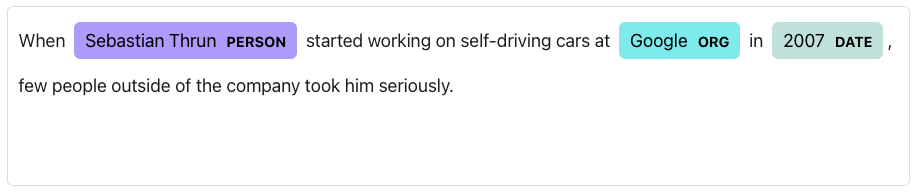

In [ ]:
displacy.serve(doc, style="dep")

# Part 7: Import ALL feedback and run the above in bulk

Most of this section is streamlined to import the merged dataset I have prepared for you and running a subset of the same cleaning routines to prepare the data for TopEx analysis.  NOTE: We do not remove stopwords or punctuation because TopEx does that for us, and we do not need to lower case either.  We DO remove all non-ascii charaters and filter out odd punctuation. For inputing a dataset to Topex, any columns that have missing values should be removed. This can be done using the command ".dropna()" as shown below.

In [ ]:
## import data file
# Import the DataFrame from the Excel file
file_path = '/lustre/home/cctr691/redcap_feedback_all_responses_Fall2024.xlsx'  
df_redcap = pd.read_excel(file_path)

# Display the first few rows of the exported DataFrame
df_redcap.head()

In [ ]:
# Subset the DataFrame to keep only the positive feedback columns
df_topex = df_redcap[['doc_id','positive_aspect']]
# We have NaN values this time, so lets remove them
df_topex.dropna(inplace=True)
df_topex.head()

In [ ]:
# Create a cleaning function including stopwords
def clean_minimal(text):
    # Remove non-ASCII characters (keep only standard English characters)
    text_ascii = text.encode('ascii', 'ignore').decode('ascii')
    # Remove extra spaces and lowercase
    text_cleaned = text_ascii.strip()
    # Remove any remaining non-alphanumeric characters
    text_cleaned = re.sub(r'[^A-Za-z0-9\s.,!?\'\"-]', '', text_cleaned)
    
    # Return the cleaned text
    return text_cleaned

In [ ]:
# Apply and view the cleaned text column
df_topex['Text'] = df_topex['positive_aspect'].apply(clean_minimal)
df_topex

Save only the doc_id and Text columns to an Excel file for TopEx.

In [ ]:
# Save the data to a text file
df_topex[['doc_id','Text']].to_excel('top_ex_ready_data.xlsx', index=False)


# Part 8: TopEx Analysis

- Download the file you just created on Athena to your desktop.

- Go to [http://topex.cctr.vcu.edu/](http://topex.cctr.vcu.edu/)

- Using the hamburger menu on the left, click on the "From Excel File" option and upload this Excel file to the TopEx platform.

- Click "Run TopEx" button and see what you get without any parameter modifications.

- Answer the questions below...

## Question 1: 
What are your observations of the default analysis?  Does it look useful?

Answer: 

## Question 2: 
Set the clustering method to Kmeans with Euclidean distance. Then play with the number of cluster, vectorization method, window size and visualization parameters.  Find a set that looks good to you and gives you some information.  Type those settings below and copy the scatter plot image and paste it below.  Also describe what type of cluster topics you found. For the image, you can take a screen shot and just paste it in from the clipboard.

Optimal Parameters:

Cluster Topic Summary:  

Scatter Plot Image:

## Question 3: 
Review the wordcloud plots.  are there any frequent words that are not helpful?  Pick a few and create a custom stopwords file. This is just a text file with one word per line, all lowercase.  Upload this file and rerun your analysis keeping all your optimal parameters.  How did this change your data?

Answer:

Scatter Plot Image:

# Appendix: Kaggle Dataset Analysis

This appendix contains code to analyze a Harvard reviews Kaggle dataset.  This data has more information in it, so you will get a more interesting TopEx analysis.  In addition, these reviews are in multiple languages, so we utilize a new package to detect the language and filter it to only those that are English.


In [ ]:
from langdetect import detect
import kagglehub

### Importing and Looking at our Data:

In [ ]:
# Download latest version
path = kagglehub.dataset_download("kanchana1990/harvard-university-ratings-and-reviews")

print("Path to dataset files:", path)

In [ ]:
#Load data from a csv file into a pandas DataFrame
file_path = path+'/harvard_reviews.csv'  # create the full file path
df = pd.read_csv(file_path) # you can instead use the command "pd.read_excel()" for .xlsx files

#Display the first few rows of the DataFrame to ensure it's loaded correctly
df.head()

In [ ]:
## create a unique index for our data
#Create a new column with a unique ID for each row
df["Doc_ID"] = 'Doc_' + df.index.astype(str)
df.tail()

### Language Detection

We can detect any non-English text and remove it from the analysis using the command "detect" from the library "langdetect".

In [ ]:
# Check for any non-English text and remove it
# First add a new column to the dataset with the detected language
df['language'] = df['text'].apply(lambda x: detect(x) if pd.notnull(x) else 'unknown')

# Identify the distribution of languages and plot them
language_counts = df['language'].value_counts()
print("\nLanguage Distribution in Text:\n", language_counts)

# Finally, keep on the data rows that are English
df = df[df['language'] == 'en']  # Keep only English rows
df

### Clean the text and Word Cloud Viz

Next, we can generate a word cloud from the remaining data to visualize frequency of major themes using the function "WordCloud()". We can generate one without stopwords and and one with them. We can check the list of stopwords included by default in spaCy using "print(nlp.Defaults.stop_words)".
WordCloud removes stopwords by default, therefore to disable this feature we need to add "stopwords=set()" as a parameter.

In [ ]:
# Create a cleaning function including stopwords
def clean_text(text):
    # Remove non-ASCII characters (keep only standard English characters)
    text_ascii = text.encode('ascii', 'ignore').decode('ascii')
    # Remove extra spaces and lowercase
    text_cleaned = text_ascii.strip().lower()
    # Remove any remaining non-alphanumeric characters
    text_cleaned = re.sub(r'[^A-Za-z0-9\s.,!?\'\"-]', '', text_cleaned)
    # Process the cleaned text through spaCy for lemmatization and stopword removal
    doc = nlp(text_cleaned)
    # Return the lemmatized text
    return " ".join([token.lemma_ for token in doc])# if not token.is_punct])

# Create a cleaning function removing stopwords
def clean_text_no_stopwords(text):
    # Remove non-ASCII characters (keep only standard English characters)
    text_ascii = text.encode('ascii', 'ignore').decode('ascii')
    # Remove extra spaces and lowercase
    text_cleaned = text_ascii.strip().lower()
    # Remove any remaining non-alphanumeric characters
    text_cleaned = re.sub(r'[^A-Za-z0-9\s.,!?\'\"-]', '', text_cleaned)
    # Process the cleaned text through spaCy for lemmatization and stopword removal
    doc = nlp(text_cleaned)
    # Return the lemmatized text without stopwords or punctuation
    return " ".join([token.lemma_ for token in doc if not token.is_stop])# and not token.is_punct])

# Apply and view the cleaned text column
df['cleaned_text'] = df['text'].apply(clean_text)
df['cleaned_text_no_stopwords'] = df['text'].apply(clean_text_no_stopwords)
df[['text', 'cleaned_text','cleaned_text_no_stopwords']].head()

In [ ]:
# Create using all words, so set stopwords to the Null set
# Combine all cleaned text into one string for word cloud generation
all_text = " ".join(df['cleaned_text'])

# Create a word cloud with all words
wordcloud = WordCloud(width=800, height=400, background_color='white',stopwords=set()).generate(all_text)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [ ]:
# Create using default SpaCy stopwords
all_text_no_stopwords = " ".join(df['cleaned_text_no_stopwords'])

# Create a word cloud with stopwords removed
wordcloud_no_stopwords = WordCloud(width=800, height=400, background_color='white', stopwords=set()).generate(all_text_no_stopwords)

# Display the word cloud without stopwords
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_no_stopwords, interpolation='bilinear')
plt.axis("off")
plt.show()

In [ ]:
# Create using default stop words PLUS custom stop words
all_text_no_stopwords = " ".join(df['cleaned_text_no_stopwords'])

STOP_WORDS = ['harvard', 'university', 'campus','tour','student']

# Create a word cloud with stopwords removed
wordcloud_no_stopwords = WordCloud(width=800, height=400, background_color='white', stopwords=STOP_WORDS).generate(all_text_no_stopwords)

# Display the word cloud without stopwords
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_no_stopwords, interpolation='bilinear')
plt.axis("off")
plt.show()

## Prep Harvard Dataset for TopEx

In [ ]:
# Subset the DataFrame to keep only specific columns and remove NA values
df_subset = df[['Doc_ID', 'text']]

# Drop NA values
df_subset.dropna(inplace=True)

# Rename column
df_subset.rename(columns={'text': 'Text'}, inplace=True)

# Export the DataFrame to an Excel file
# Note we are only exporting a subset of the data because TopEx was crashing on the full dataset as the online server is small.
df_subset[0:800].to_excel('/lustre/home/alolex/CCTR691/24.10.24_NLPLab/top_ex_ready_data_Harvard.xlsx', index=False)


## TopEx Analysis

Like before, go to your Athena drive and download this dataset.  Then import into TopEx and explor as before!

# Appendix

The follow code is what I used to create the csv file you just imported

In [ ]:
api_keys_auto = {'Panguluri':'30B03AD44291C56E3D07D88B8648E7D2','Way':'1D044BDD3F1F11A87AC84403F351F2F8',
            'AbaidooMyles':'2039C03ADF1B1F416AD5ED3E017CBAC1','Naik':'3F1D8C07B623DF87A43C08ABB29E14C9'}

api_keys_manual = {'Stadtler':'ABA571C5EC78E3FB8D4008DABA5DB182','Camarena':'BCAD8BD1240AC6097E933DA55FA183AC',
            'Abosamak':'DBFCC6C880132E475475FDF0C896F3DF','Gibson':'65416D1024A6EC2FFE39613FBE92A017'}

In [ ]:
main_df = pd.DataFrame()
for k,v in api_keys_auto.items():
    data = {
        'token': v,
        'content': 'record',
        'action': 'export',
        'format': 'csv',
        'type': 'flat',
        'csvDelimiter': '',
        'rawOrLabel': 'raw',
        'rawOrLabelHeaders': 'raw',
        'exportCheckboxLabel': 'false',
        'exportSurveyFields': 'false',
        'exportDataAccessGroups': 'false',
        'returnFormat': 'json'
    }

    api_data = requests.post('https://redcap.vcu.edu/api/',data=data)
    df = pd.read_csv(StringIO(api_data.text), sep=",").iloc[:,[0,7,8]]
    df['doc_id'] = k + "_" + df.index.astype(str)
    main_df = pd.concat([main_df,df])
    
main_df    

In [ ]:
## Set up REDCap Connection
api_keys_manual = {'Stadtler':'ABA571C5EC78E3FB8D4008DABA5DB182','Camarena':'BCAD8BD1240AC6097E933DA55FA183AC',
            'Abosamak':'DBFCC6C880132E475475FDF0C896F3DF','Gibson':'65416D1024A6EC2FFE39613FBE92A017'}



In [ ]:
api_keys_manual['Stadtler']

In [ ]:
## Stadtler
data = {
        'token': api_keys_manual['Stadtler'],
        'content': 'record',
        'action': 'export',
        'format': 'csv',
        'type': 'flat',
        'csvDelimiter': '',
        'rawOrLabel': 'raw',
        'rawOrLabelHeaders': 'raw',
        'exportCheckboxLabel': 'false',
        'exportSurveyFields': 'false',
        'exportDataAccessGroups': 'false',
        'returnFormat': 'json'
    }

api_data = requests.post('https://redcap.vcu.edu/api/',data=data)
df = pd.read_csv(StringIO(api_data.text), sep=",").iloc[:,[0,15,16]]
df.rename(columns={'positive_feedback': 'positive_aspect', 'negative_feedback': 'negative_aspect'}, inplace=True)
df['doc_id'] = "Stadtler_" + df.index.astype(str)
main_df = pd.concat([main_df,df])
    

In [ ]:
## Camarena
data = {
        'token': api_keys_manual['Camarena'],
        'content': 'record',
        'action': 'export',
        'format': 'csv',
        'type': 'flat',
        'csvDelimiter': '',
        'rawOrLabel': 'raw',
        'rawOrLabelHeaders': 'raw',
        'exportCheckboxLabel': 'false',
        'exportSurveyFields': 'false',
        'exportDataAccessGroups': 'false',
        'returnFormat': 'json'
    }

api_data = requests.post('https://redcap.vcu.edu/api/',data=data)
df = pd.read_csv(StringIO(api_data.text), sep=",").iloc[:,[0,7,8]]

df.rename(columns={'escribe_1_or_more_specific_positive_aspect_s_of_this_lecture_that_you_liked_or_were_accessible_to_y': 'positive_aspect', 'describe_1_or_more_specifi': 'negative_aspect'}, inplace=True)
df['doc_id'] = "Camarena_" + df.index.astype(str)
main_df = pd.concat([main_df,df])



In [ ]:
## Abosamak
data = {
        'token': api_keys_manual['Abosamak'],
        'content': 'record',
        'action': 'export',
        'format': 'csv',
        'type': 'flat',
        'csvDelimiter': '',
        'rawOrLabel': 'raw',
        'rawOrLabelHeaders': 'raw',
        'exportCheckboxLabel': 'false',
        'exportSurveyFields': 'false',
        'exportDataAccessGroups': 'false',
        'returnFormat': 'json'
    }

api_data = requests.post('https://redcap.vcu.edu/api/',data=data)
df = pd.read_csv(StringIO(api_data.text), sep=",").iloc[:,[0,7,8]]
df.columns
df.rename(columns={'positive_txt': 'positive_aspect', 'negative_txt': 'negative_aspect'}, inplace=True)
df['doc_id'] = "Abosamak_" + df.index.astype(str)
main_df = pd.concat([main_df,df])

In [ ]:
## Gibson
data = {
        'token': api_keys_manual['Gibson'],
        'content': 'record',
        'action': 'export',
        'format': 'csv',
        'type': 'flat',
        'csvDelimiter': '',
        'rawOrLabel': 'raw',
        'rawOrLabelHeaders': 'raw',
        'exportCheckboxLabel': 'false',
        'exportSurveyFields': 'false',
        'exportDataAccessGroups': 'false',
        'returnFormat': 'json'
    }

api_data = requests.post('https://redcap.vcu.edu/api/',data=data)
df = pd.read_csv(StringIO(api_data.text), sep=",").iloc[:,[0,8,9]]
df.columns
df.rename(columns={'positive_aspects': 'positive_aspect', 'negative_aspects': 'negative_aspect'}, inplace=True)
df['doc_id'] = "Gibson_" + df.index.astype(str)
main_df = pd.concat([main_df,df])

In [ ]:
main_df.shape


In [ ]:
# Export the DataFrame to an Excel file
main_df.to_excel('/lustre/home/cctr691/redcap_feedback_all_responses_Fall2024.xlsx', index=False)


In [ ]:
# Create a cleaning function including stopwords
def clean_minimal(text):
    # Remove non-ASCII characters (keep only standard English characters)
    text_ascii = text.encode('ascii', 'ignore').decode('ascii')
    # Remove extra spaces and lowercase
    text_cleaned = text_ascii.strip().lower()
    # Remove any remaining non-alphanumeric characters
    text_cleaned = re.sub(r'[^A-Za-z0-9\s.,!?\'\"-]', '', text_cleaned)
    
    # Return the cleaned text
    return text_cleaned